## Load Packages

In [1]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *
from tqdm import tqdm
import time
import scipy.stats as sps
from scipy.optimize import minimize
import scipy.stats as sps

In [ ]:
from EITP.SDE.Model1 import IndexTracker as firstModel;


## Pre-Processing of Data

In [2]:
# Define the data set of interest
simType = "IS";
whichData = "UD";
totalPeriods = 52;

# Load core data 
inSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(whichData), header=None);
outSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-{}.csv".format(whichData), header=None);

# Out-of-sample data in returns
IndexOoS = outSample.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS = IndexOoS[1:];
AssetsOoS = outSample.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS = AssetsOoS[1:];

# In-sample data is in returns
IndexIS = inSample.iloc[:,0].values
AssetsIS = inSample.iloc[:,1:].values

# Then we wish to construct the initial weights of the index
# As these could not be found, we form an optimization model to match the first term exactly
T,N = AssetsOoS.shape
w = np.ones(N)*1/N
#w = np.zeros(N)
#w[0] = 1

def objective(w):
    return np.abs(IndexOoS[0] - AssetsOoS[0,:] @ w)

# Constraints: The weights should sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights: No shorting allowed
bounds = [(0, None) for _ in range(N)]

# Call the optimizer
result = minimize(objective, w, bounds=bounds, constraints=constraints, tol=np.finfo(float).eps)

# Extract the optimal weights
optimal_weights = result.x

# Construction of log-returns
if simType == "OoS":
    logIndex = np.reshape(np.log(IndexOoS + 1), (AssetsOoS.shape[0], 1))
    logAssets = np.log(AssetsOoS + 1) 
    logAugmented = np.concatenate((logIndex, logAssets), axis=1)
else:
    logIndex = np.reshape(np.log(IndexIS + 1), (AssetsIS.shape[0], 1))
    logAssets = np.log(AssetsIS + 1) 
    logAugmented = np.concatenate((logIndex, logAssets), axis=1)

# How is the data actually distributed?

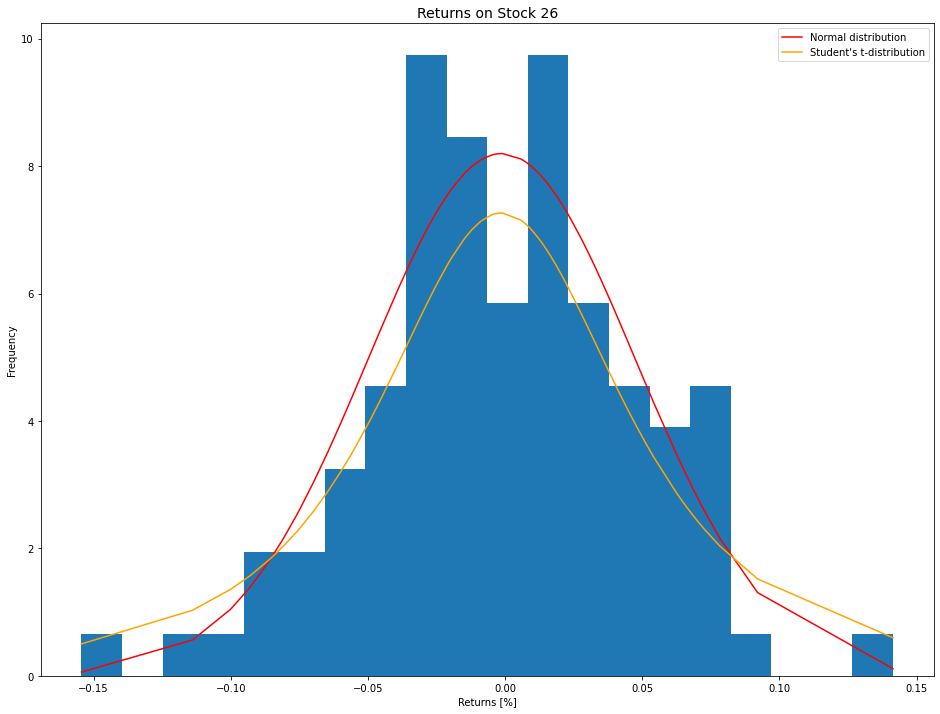

In [3]:
stock = 26
plt.figure(figsize=(16,12))
plt.hist(logAssets[:,stock], bins = 20, density = True)
plt.plot(np.sort(logAssets[:,stock]), sps.norm.pdf(np.sort(logAssets[:,stock]), loc=np.mean(logAssets[:,stock]), scale=np.std(logAssets[:,stock])), color = 'red', label = "Normal distribution")
plt.plot(np.sort(logAssets[:,stock]), sps.t.pdf(np.sort(logAssets[:,stock]), 2, loc=np.mean(logAssets[:,stock]), scale=np.std(logAssets[:,stock])), color = 'orange', label = "Student's t-distribution")
plt.xlabel("Returns [%]")
plt.ylabel("Frequency")
plt.title("Returns on Stock {}".format(stock), fontsize = 14)
plt.legend()
plt.show()
plt.show()

Hard to say from so little data.

# 1. Geometric Brownian Motion (GBM)

The following model is used to simulate normal market conditions. These will be defined as periods where simulated paths are continuous and hence jump-free.

## 1.1 Validation of Parameter Fitting  (Multivariate GBM)

In [37]:
def f(mu, S):
    return mu*S

def g(sigma, S):
    return sigma*S

length = 10000
dt = 0.001

S = np.zeros((1,length))
S[0,0] = 1
dW = np.random.normal(0,dt,size=length)

# Parameters
mu = 0.07
sigma = 0.15

for i in range(1,length):
    S[0,i] = S[0,i-1] + f(mu,S[0,i-1])*dt + g(sigma,S[0,i-1])*dW[i-1]

In [40]:
os.listdir()

['Main Model.ipynb',
 'stock_data',
 'portfolio_tools.py',
 'Log-Returns.ipynb',
 '.DS_Store',
 'Robust MVO with Factor Model.ipynb',
 'Configuration.ipynb',
 'Data Exploration (Guastaroba).ipynb',
 'Data Exploration.ipynb',
 'Solvers',
 '__pycache__',
 'README.md',
 'Enhanced Index Tracking with CVAR-Based Ratio Measures.ipynb',
 'Figures',
 'Scenario Generation.ipynb',
 'test.txt',
 '.ipynb_checkpoints',
 '.git',
 'Data',
 'EITP',
 'Plots',
 'Affine Functions.ipynb',
 'Mean-Variance Optimization.ipynb']

## 1.2 Parameter Fitting with Market Data (Multivariate GBM)

In [ ]:
T,N = logAssets.shape

# Find regular MLE
ExpectedLogReturns = np.mean(logAugmented, axis=0)
CovLogReturns = np.cov(logAugmented, rowvar=False)

# Then we decompose CovLogReturns
lambdas, Q = np.linalg.eigh(1/T*CovLogReturns + np.identity(N+1)*(10**(-16)))
L = np.diag(lambdas)

# Then we find the estimates for GBM
hatSigma = Q @ L**(1/2) @ Q.T
hatMu = np.diagonal(hatSigma @ hatSigma.T) + 1/T*ExpectedLogReturns

## 1.3 Simulation

We start by showing the out-of-sample data.

In [ ]:
# Create the paths
realIndexPathOoS = np.concatenate((np.array([1]), np.cumprod(IndexOoS + 1, axis=0)), axis=0)*100
realAssetPathOoS = np.concatenate((np.ones((1,100)), np.cumprod(AssetsOoS + 1, axis=0)), axis=0)*100

# Create figure
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(realAssetPathOoS, alpha = 0.60);
ax.plot(realIndexPathOoS, color="black", label="FTSE 100", linewidth=3)
ax.set_ylim(bottom=60, top=170)

# Title, labels and grid
ax.set_xlabel("Periods", fontsize=18);
ax.set_ylabel("Index [period 0 = 100]", fontsize=18);
ax.legend(loc="upper left", fontsize=24);
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.savefig('./Plots/ActualOoS.png', dpi=100);
plt.show()

Then we show simulations.

In [ ]:
# Create simulation
np.random.seed(267)
forecastReturns = np.exp(np.random.multivariate_normal(ExpectedLogReturns, CovLogReturns, size=totalPeriods, check_valid='warn', tol=1e-8))
cummulativeForecastReturns = np.cumprod(forecastReturns, axis=0)
stockPaths = np.concatenate((np.ones((1,101)), cummulativeForecastReturns), axis=0) * 100
indexPaths = stockPaths[:,0]

# Create figure
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(stockPaths, alpha = 0.60);
ax.plot(indexPaths, color="black", label="FTSE 100", linewidth=3)
ax.set_ylim(bottom=60, top=170)

# Title, labels and grid
ax.set_xlabel("Periods", fontsize=18);
ax.set_ylabel("Index [period 0 = 100]", fontsize=18);
ax.legend(loc="upper left", fontsize=24);
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.savefig('./Plots/SimulatedOoS.png', dpi=100);
plt.show()

# 2. Kou's Jump Diffusion

We start by simulating a univariate version of Merton's Jump Diffusion model.

In [ ]:
dates = np.arange(1,105,1)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(dates, logIndex, label="log(return)")
ax.plot(dates, np.repeat(np.mean(logIndex), 104), color="black", label="E[log(return)]")
ax.plot(dates, np.repeat(2*np.std(logIndex), 104), color="red", label="STD[log(return)]")
ax.plot(dates, np.repeat(-2*np.std(logIndex), 104), color="red")
ax.legend()
plt.show()

In [ ]:
# Poisson Process
intensity = 4/52
N = np.zeros(105)

# Assymetric Double Exponential
p1 = 0.7
p2 = 1 - p1
eta1 = 1.8
eta2 = 1.5

intensity = 15/104
S0 = 100
mu = 0.11
sigma = 0.11
sigmaJump = 0.90
St = np.zeros(105)
MJD = np.zeros(105)
St[0] = S0
MJD[0] = S0
dt = 1/104

for i in range(1, len(St)):
    dW = np.sqrt(dt) * np.random.normal(loc=0,scale=1)
    processJumps[i] = np.random.binomial(1, intensity)
    dN = sigmaJump * processJumps[i] * np.random.normal(loc=-0.05, scale=1, size=1)
    St[i] = St[i-1] + (mu*St[i-1]*dt + sigma*St[i-1]*dW)

In [ ]:
dates = np.arange(0,105,1)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(dates, St, color="black", label="GBM")

MJDSegments = np.argwhere(processJumps == np.amax(processJumps))
ax.plot(dates[0:MJDSegments[0][0]], MJD[0:MJDSegments[0][0]], color="red", label="MJD")
for i in range(1, len(MJDSegments)):  
    ax.plot(dates[MJDSegments[i-1][0]:dates[MJDSegments[i][0]]], MJD[MJDSegments[i-1][0]:dates[MJDSegments[i][0]]], color="red")
ax.plot(dates[MJDSegments[-1][0]:], MJD[MJDSegments[-1][0]:], color="red")

ax.legend()
plt.show()